# This notebook contains the code and figures for the data from measuring display latencies

What data do we have?

    A. Light intensity over time
    B. (A) for multiple trials
    C. (B) for different frame rate (FR), resolution, and modes
    D. (C) for different monitor/projector

What information to extract?

    A. How light is being shone by the monitor/projector in every trial
    B. How does the latency changes over time
    C. Distribution of light intensity for the whole experiment - histogram of (A)
    D. Distribution of latencies for the whole experiment
    E. (A, B, C, and D) across different FR, resolution, modes
    F. (A, B, C, and D) across different monitors (For the same FR, resolution, modes)
    G. Mean latency versus FR across across different monitors
    H. Mean latency versus Resolution across different monitors
    
Related to our device: 

    I. What is the sampling frequency of our device

---

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import seaborn as sns
import os
import glob
from tqdm import tqdm

import vrlatency as vrl

## Import Data

In [2]:
path_data = "../../data/"
path_fig = "../../Figures/display/"

os.chdir(path_data)

In [3]:
df_data_all = pd.DataFrame()
df_params_all = pd.DataFrame()

for filename in tqdm(glob.glob('*.csv')):
    name = filename.split('.')[0]
    
    df_data = vrl.read_csv(filename)
    df_data['Session'] = name
    params = vrl.read_params(filename)
    params_series = pd.Series(params)
    params_series.name = name
    
    df_data_all = df_data_all.append(df_data)
    df_params_all = df_params_all.append(params_series)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:13<00:00,  2.03it/s]


In [4]:
df_params_all.head()

,Date,Depth,Experiment,Height,Monitors,Rate,Time,Trials,Width
display_20180830_115317,30.08.2018,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,11:51:10,1000,1920
display_20180830_123133,30.08.2018,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,120,12:29:25,1000,1920
display_20180830_123445,30.08.2018,32,DisplayExperiment,1024,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,12:32:37,1000,1280
display_20180830_124007,30.08.2018,32,DisplayExperiment,720,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,12:37:59,1000,1280
display_20180830_124242,30.08.2018,32,DisplayExperiment,768,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,12:40:34,1000,1024


## Fix Params dataframe dtypes

In [5]:
dfp = df_params_all.copy()
int_params = ['Width', 'Height', 'Depth', 'Rate', 'Trials']
dfp[int_params] = df_params_all[int_params].astype(int)
dfp['Timestamp'] = pd.to_datetime(df_params_all.Date.str.cat(df_params_all.Time, sep=' '), format="%d.%m.%Y %H:%M:%S")
del dfp['Time']
del dfp['Date']
dfp.head().dtypes

Depth                  int32
Experiment            object
Height                 int32
Monitors              object
Rate                   int32
Trials                 int32
Width                  int32
Timestamp     datetime64[ns]
dtype: object

## Data Transformation

In [6]:
dfp['Pixels'] = dfp['Height'] * dfp['Width']
dfp.head(3)

,Depth,Experiment,Height,Monitors,Rate,Trials,Width,Timestamp,Pixels
display_20180830_115317,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,1000,1920,2018-08-30 11:51:10,2073600
display_20180830_123133,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,120,1000,1920,2018-08-30 12:29:25,2073600
display_20180830_123445,32,DisplayExperiment,1024,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,1000,1280,2018-08-30 12:32:37,1310720


In [7]:
df= df_data_all.copy()
df['Time'] = df['Time'] / 1000
trials = df.groupby(['Session', 'Trial'])
df['TrialTime'] = trials.Time.apply(lambda x: x - x.min())
df['Sample'] = trials.cumcount()
df['Session'] = pd.Categorical(df['Session'])
df.head()

,Trial,Time,SensorBrightness,Session,TrialTime,Sample
0,2,813.068,0,display_20180830_115317,0.000,0
1,2,813.340,0,display_20180830_115317,0.272,1
2,2,813.612,0,display_20180830_115317,0.544,2
3,2,813.884,0,display_20180830_115317,0.816,3
4,2,814.156,0,display_20180830_115317,1.088,4


In [8]:
df = df.reindex(['Session', 'Trial', 'Sample', 'Time', 'TrialTime', 'SensorBrightness'], axis=1)
df.head()

,Session,Trial,Sample,Time,TrialTime,SensorBrightness
0,display_20180830_115317,2,0,813.068,0.000,0
1,display_20180830_115317,2,1,813.340,0.272,0
2,display_20180830_115317,2,2,813.612,0.544,0
3,display_20180830_115317,2,3,813.884,0.816,0
4,display_20180830_115317,2,4,814.156,1.088,0


Time to beat:

In [9]:
# %timeit vrl.get_display_latencies(dd)

current time:

In [10]:
# %load_ext line_profiler

In [11]:
# %timeit vrl.get_display_latencies(dd)

In [12]:
# %lprun -f vrl.get_display_latencies vrl.get_display_latencies(dd)

In [9]:
thresh=.75
latencies = df.groupby('Session').apply(vrl.get_display_latencies, thresh=thresh).reset_index()
# latencies.name = 'DisplayLatency'
# latencies = latencies.reset_index()
latencies.head()

,Session,Trial,DisplayLatency
0,display_20180830_115317,2,38.488
1,display_20180830_115317,3,29.504
2,display_20180830_115317,4,28.664
3,display_20180830_115317,5,19.376
4,display_20180830_115317,6,34.672


In [10]:
dfl = pd.merge(df, latencies, on=['Session', 'Trial'])
dfl['TrialTransitionTime'] = dfl['TrialTime'] - dfl['DisplayLatency']
dfl.head()

,Session,Trial,Sample,Time,TrialTime,SensorBrightness,DisplayLatency,TrialTransitionTime
0,display_20180830_115317,2,0,813.068,0.000,0,38.488,-38.488
1,display_20180830_115317,2,1,813.340,0.272,0,38.488,-38.216
2,display_20180830_115317,2,2,813.612,0.544,0,38.488,-37.944
3,display_20180830_115317,2,3,813.884,0.816,0,38.488,-37.672
4,display_20180830_115317,2,4,814.156,1.088,0,38.488,-37.400


## Session Analysis

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:13<00:00, 71.75it/s]


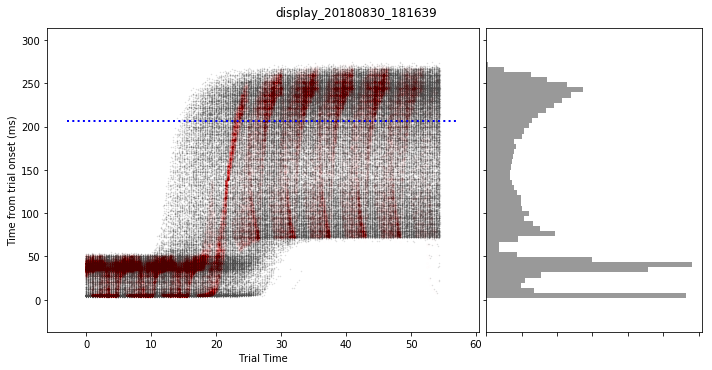

In [219]:
sess_id = 16
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]

hh = np.array(get_transition_samplenum(dd))
hh = hh[~np.isnan(hh)]
hh = hh.astype(int)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
ax1, ax2 = axes

ax1.scatter(dd.TrialTime, dd.SensorBrightness, c='.3', s=.2, alpha=.2);

shifted_trials = pd.DataFrame()

for trial in tqdm(range(dd.Trial.min(), dd.Trial.max(), 1)):

    test_trialnum = trial
    test_trial = dd[dd.Trial == test_trialnum]

    fastest_transtion_sample = hh.mean().round().astype(int)

    try:
        test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
        offset = test_transition_sample - fastest_transtion_sample
    except IndexError:
        offset = -1

    if offset >= 0:
#         ax1.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
#                     test_trial.SensorBrightness.values[offset:], c='r', s=1, alpha=.05);
        shifted_trial = test_trial.SensorBrightness[offset:].to_frame().reset_index(drop=True)
        shifted_trial['Sample'] = range(0, shifted_trial.shape[0])
        shifted_trial['Trial'] = test_trialnum
        shifted_trial['TrialTime'] = test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset])
        shifted_trials = shifted_trials.append(shifted_trial)
        
ax1.scatter(shifted_trials.TrialTime, shifted_trials.SensorBrightness, c='r', s=8, alpha=.002)

# average_time = shifted_trials.groupby('Sample').TrialTime.mean()
# average_brightness = shifted_trials.groupby('Sample').SensorBrightness.mean()
# ax1.plot(average_time, average_brightness, 'r', alpha=.5, linewidth=2)
# ax1.scatter(average_time, average_brightness, c='r')
        
thresh = 0.75
ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'b', label='Threshold', linewidth=2, linestyle='dotted');

sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
ax2.set(xticklabels='')

ax1.set(xlabel='Trial Time', ylabel='Time from trial onset (ms)')

fig.suptitle(session, y=1.02)
fig.tight_layout(w_pad=0)
fig;

---

### Summary of the shifting algortihm

Includes two steps of shifiting:
    - find the fastest trial (the trial that has the earliest transition over the threshold) - we call this the ref_trial
    - find the cross-correlation between the ref_trial and all the shifted trials

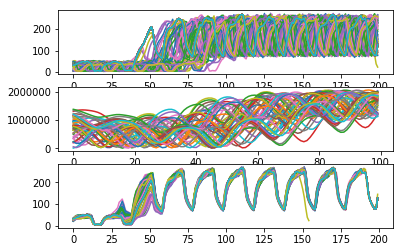

In [78]:
sess_id = 16  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

s2 = dd[dd.DisplayLatency == dd.DisplayLatency.min()].SensorBrightness.values

for trialnum in range(dd.Trial.min(), dd.Trial.max(), 20):
    s1 = dd[dd.Trial==trialnum].SensorBrightness.values

    ax1.plot(s1)
    ax1.plot(s2)

    offsets = 100    
    s1_mat = np.ndarray(buffer=s1, shape=(len(s1)-offsets, offsets), strides=(8, 8), dtype=s1.dtype)
    residuals = np.sum((s1_mat.T - s2[:-offsets]) ** 2, axis=1)

    ax2.plot(residuals)

    sampling_rate = np.diff(dd.TrialTime.values[:2])[0]
    ax3.plot(s1[np.argmin(residuals):])
    ax3.plot(s2)

c:\users\mohammad bashiri\anaconda3\envs\vrlatency3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


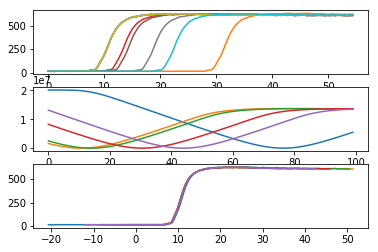

In [129]:
sess_id = 25  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

ref_trial = dd[dd.DisplayLatency == dd.DisplayLatency.min()]
s2 = ref_trial.SensorBrightness.values

for trialnum in range(dd.Trial.min(), dd.Trial.max(), 20):
    
    trial1 = dd[dd.Trial==trialnum]
    s1 = trial1.SensorBrightness.values
    
    ax1.plot(ref_trial.TrialTime, ref_trial.SensorBrightness)
    ax1.plot(trial1.TrialTime, trial1.SensorBrightness)

    offsets = 100    
    s1_mat = np.ndarray(buffer=s1, shape=(len(s1)-offsets, offsets), strides=(8, 8), dtype=s1.dtype)
    residuals = np.sum((s1_mat.T - s2[:-offsets]) ** 2, axis=1)

    ax2.plot(residuals)

    sampling_rate = np.diff(dd.TrialTime.values[:2])[0]   
    trial1['TrialTransitionTime'] = dd['TrialTime'] - np.argmin(residuals)  * sampling_rate
    ax3.plot(trial1.TrialTransitionTime.values, trial1.SensorBrightness.values)

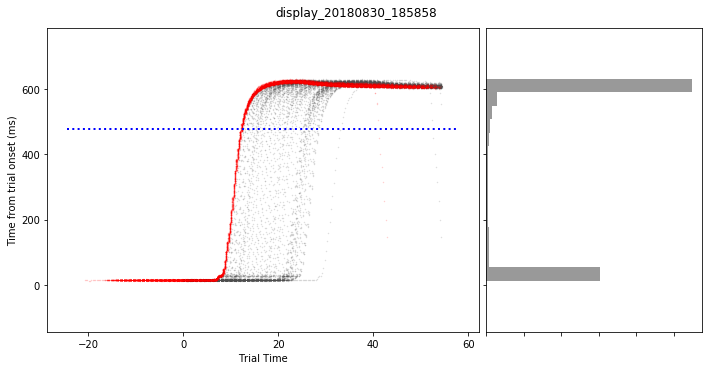

In [130]:
sess_id = 25  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

######################
# dd['TrialTransitionTime'] += dd.groupby('Trial').DisplayLatency.mean().mean()

#######################
def shift_by_cross_corr(test_sensor, ref_sensor, offset_range=(-20, 20)):
    s1, s2 = test_sensor.values, ref_sensor.values
    offsets = 100
    s1_mat = np.ndarray(buffer=s1, shape=(len(s1)-offsets, offsets), strides=(8, 8), dtype=s1.dtype)
    residuals = np.sum((s1_mat.T - s2[:-offsets]) ** 2, axis=1)
    return np.argmin(residuals)

sampling_rate = np.diff(dd.TrialTime.values[:2])[0]
ref_trial = dd[dd.DisplayLatency == dd.DisplayLatency.min()]
dd['TransitionOffset'] = dd.groupby('Trial').SensorBrightness.transform(shift_by_cross_corr, ref_sensor=ref_trial.SensorBrightness)
dd['TrialTransitionTime'] = dd['TrialTime'] - dd['TransitionOffset']  * sampling_rate
############################

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
ax1, ax2 = axes

# plot the brightness values for all the trials
ax1.scatter(dd.TrialTime, dd.SensorBrightness, c='.3', s=.2, alpha=.2);
ax1.scatter(dd.TrialTransitionTime, dd.SensorBrightness, c='r', s=.2, alpha=.2)

ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'b', label='Threshold', linewidth=2, linestyle='dotted');

sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
ax2.set(xticklabels='')
ax1.set(xlabel='Trial Time', ylabel='Time from trial onset (ms)')
fig.suptitle(session, y=1.02)
fig.tight_layout(w_pad=0)
fig;

---

## Latencies

c:\users\mohammad bashiri\anaconda3\envs\vrlatency3\lib\site-packages\matplotlib-2.2.2-py3.6-win-amd64.egg\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


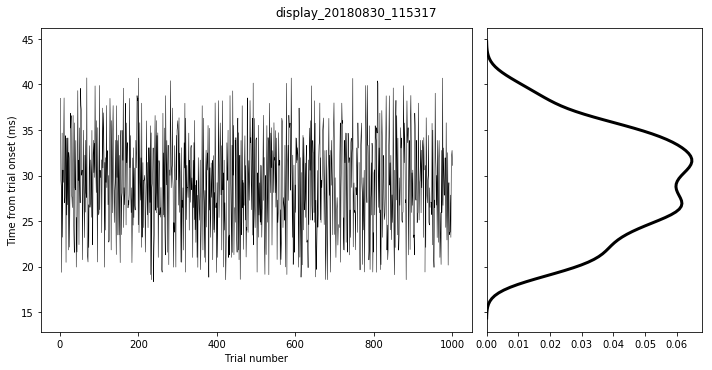

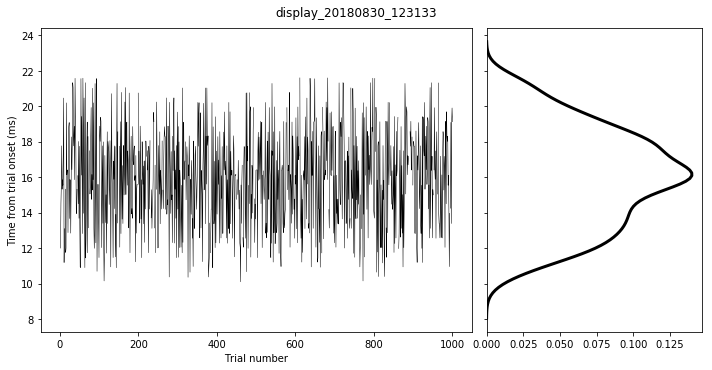

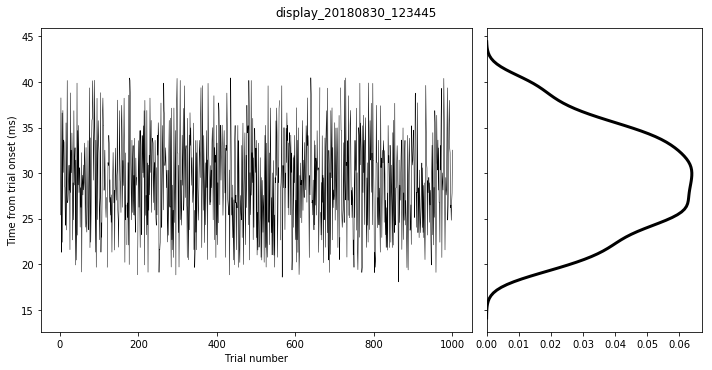

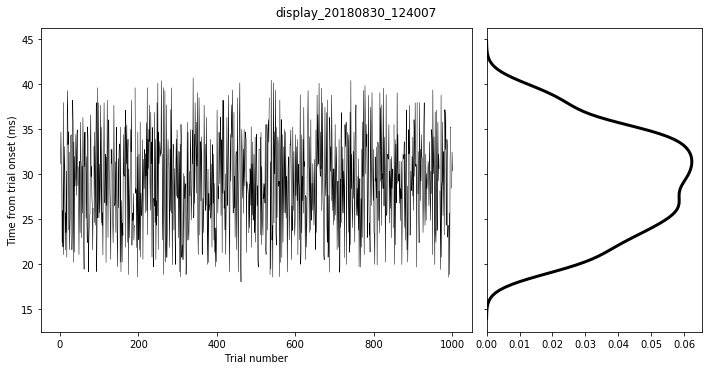

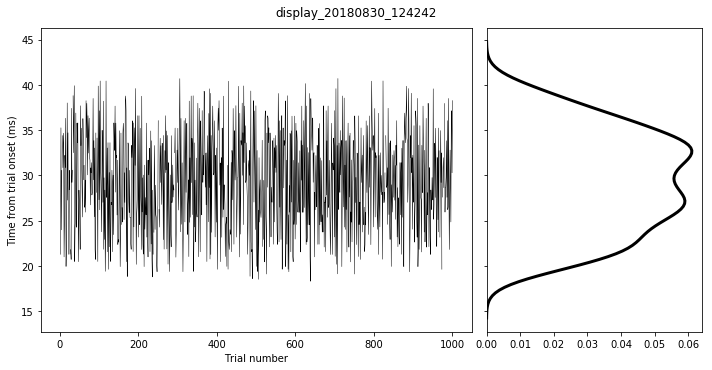

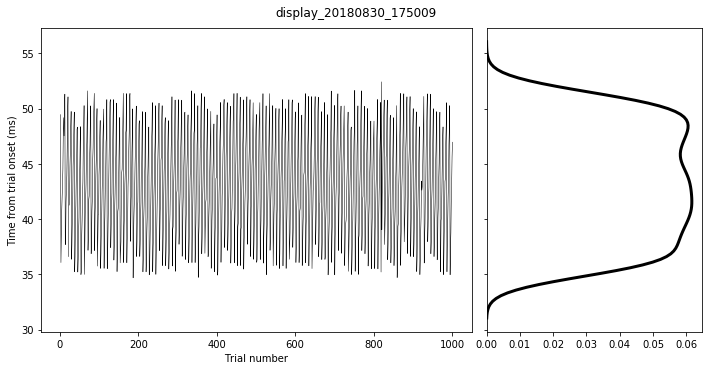

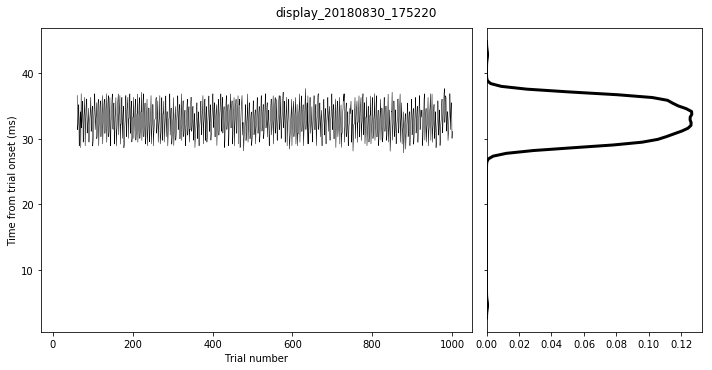

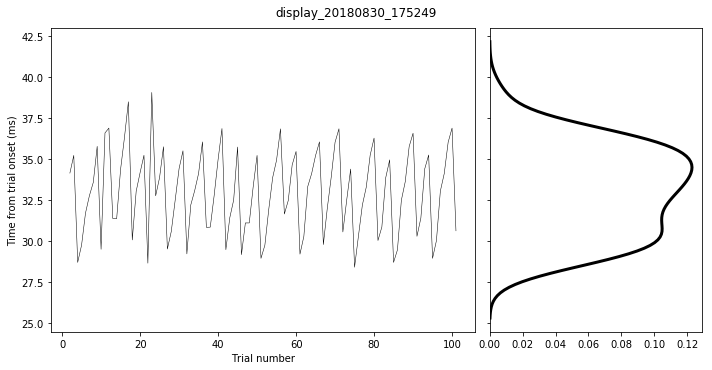

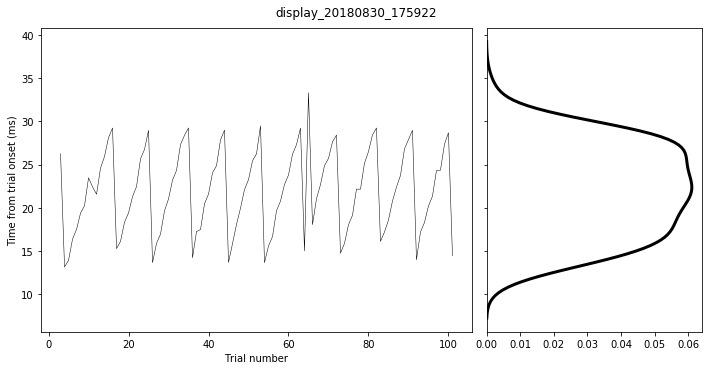

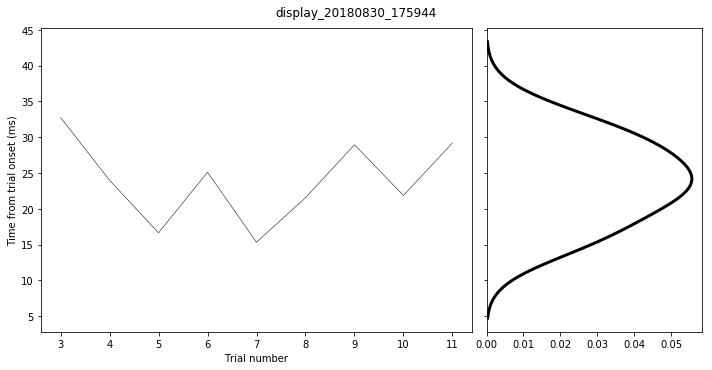

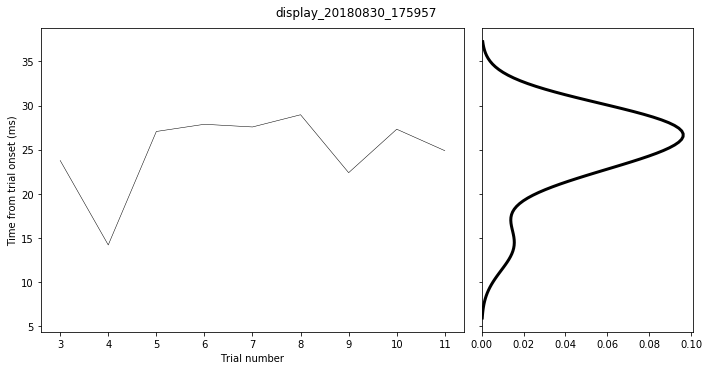

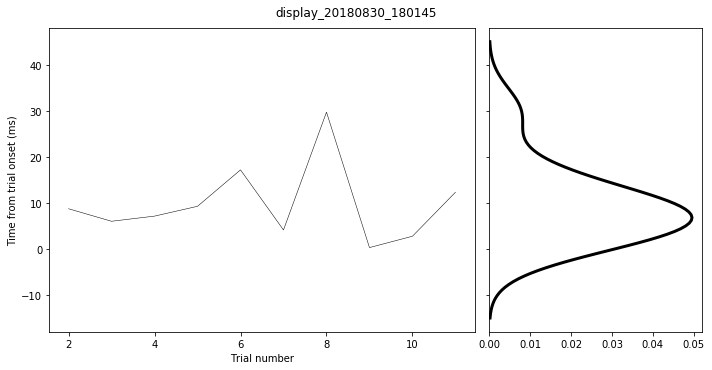

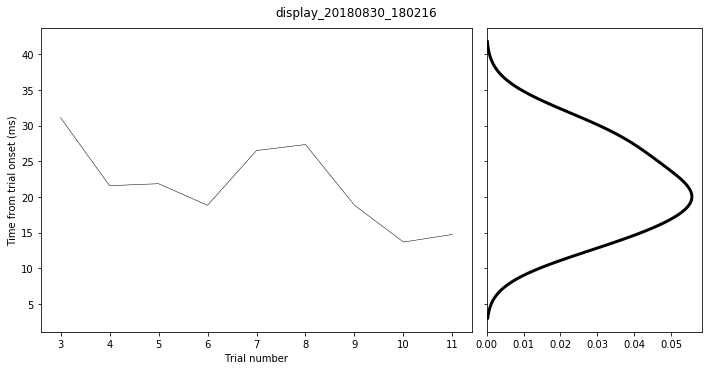

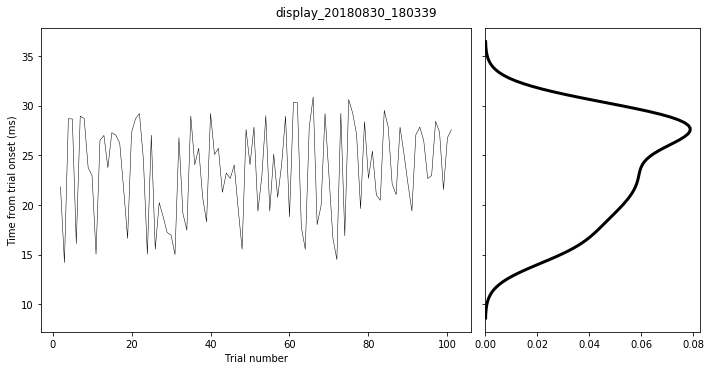

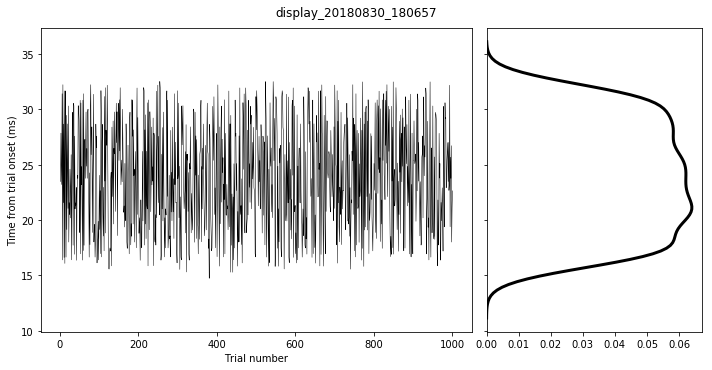

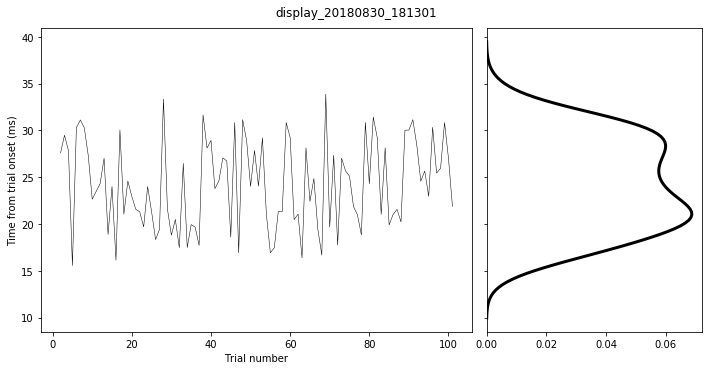

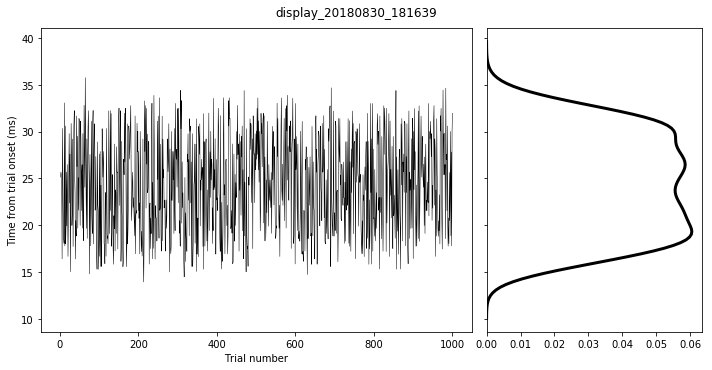

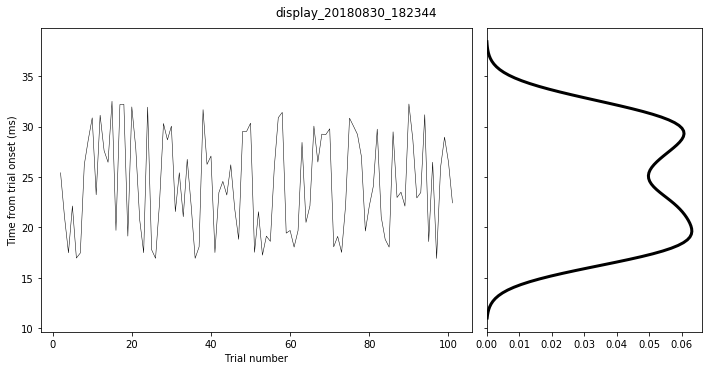

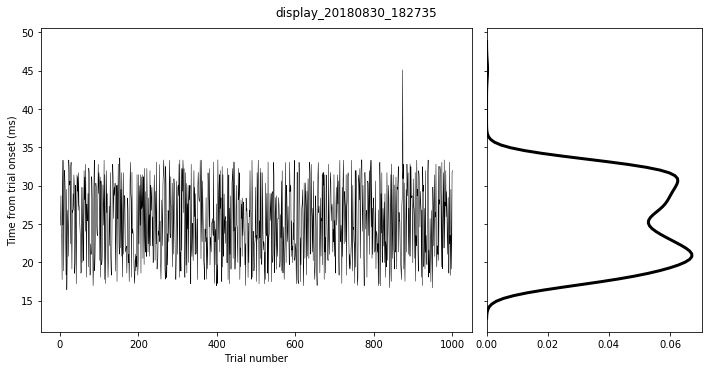

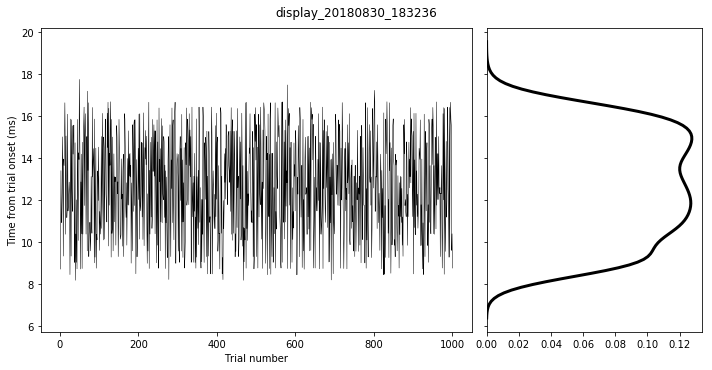

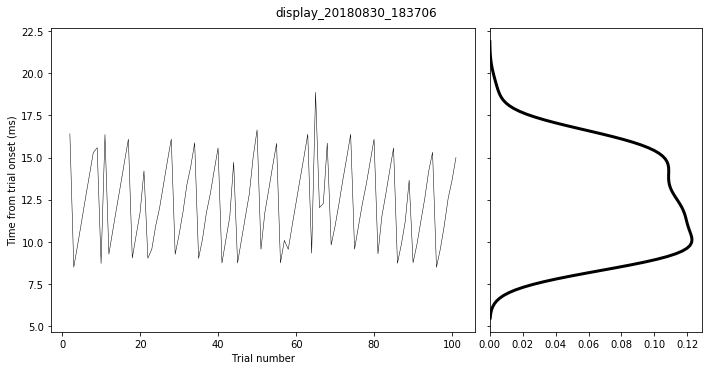

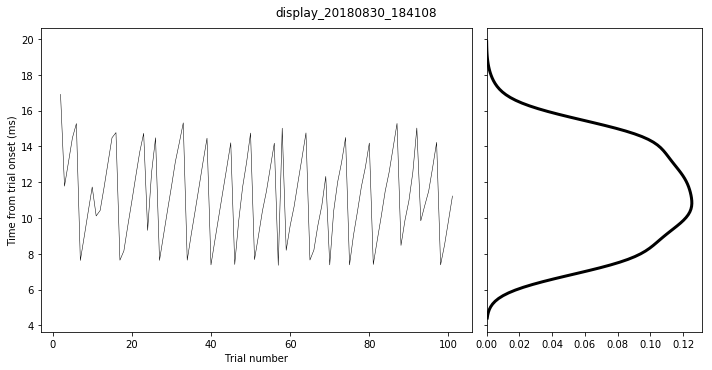

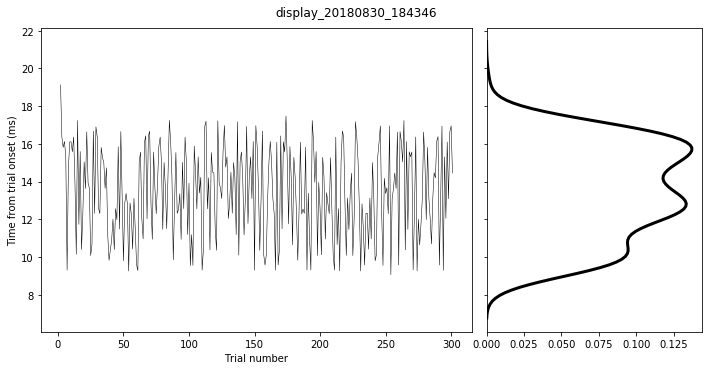

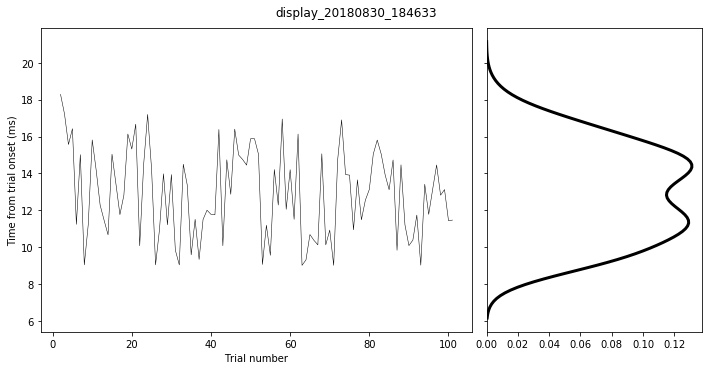

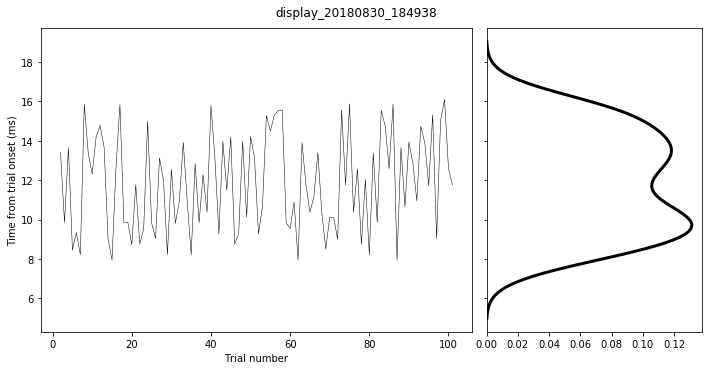

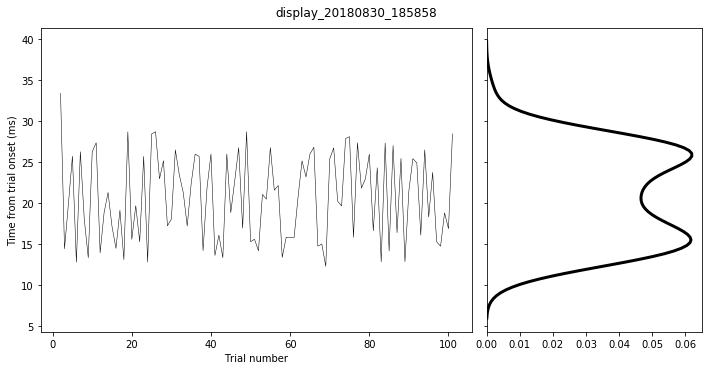

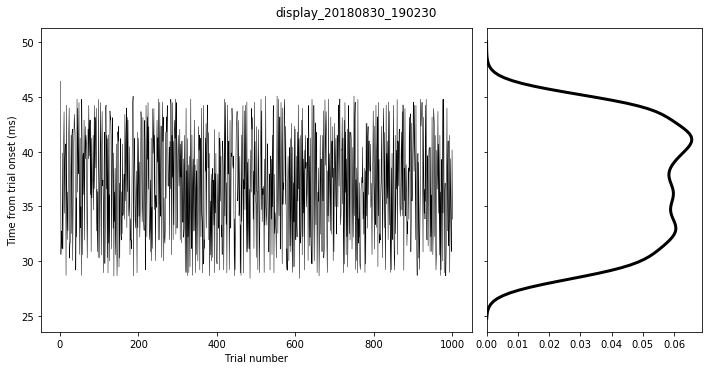

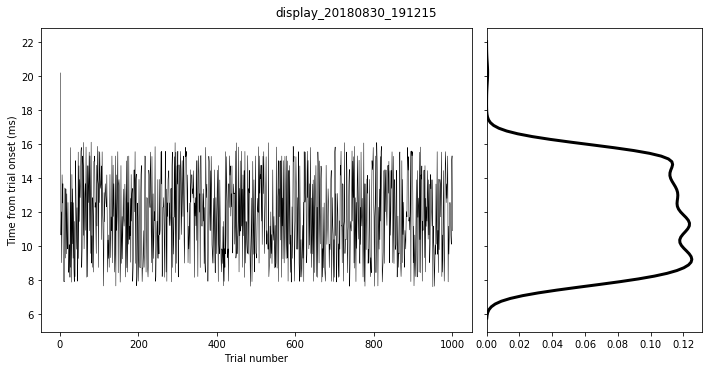

In [17]:
for sess_id in range(0, 28):
    session = dfp.iloc[sess_id].name
    dl = latencies[latencies['Session'] == session]

    fig, axes= plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
    (ax1, ax2) = axes

    ax1.plot(dl['Trial'], dl['DisplayLatency'], c='k', linewidth=.5);
    sns.distplot(dl['DisplayLatency'].dropna().values, hist=False, color="k", kde_kws={"linewidth": 3, "alpha": 1}, 
                 ax=axes[1], vertical=True);
    ax1.set(ylabel='Time from trial onset (ms)')
    ax1.set_xlabel('Trial number')

    fig.tight_layout(w_pad=0)
    fig.suptitle(session, y=1.02)
    fig;
    plt.savefig(path_fig + session + '_' + str(sess_id) + '_latencies.png')

---

## Aggregation analysis

In [76]:
df_data = df_data_all.copy()
df_params = df_params_all.copy()

Merge the df_data_all with df_latency

In [82]:
df_data_latency = pd.merge(df_data_all, df_latency, on=['Session', 'Trial'])
df_data_latency.tail()

,Trial,Time,SensorBrightness,Session,Latency
2547995,1001,143434284,604,27,10912.0
2547996,1001,143434556,606,27,10912.0
2547997,1001,143434828,604,27,10912.0
2547998,1001,143435100,604,27,10912.0
2547999,1001,143435372,606,27,10912.0


Merge the df_params_all with df_latency

In [86]:
df_params_latency = pd.merge(df_latency, df_params, on='Session')
df_params_latency.head()

,Session,Trial,Latency,Experiment,Date,Time,Width,Height,Depth,Rate,Monitors,Trials,Filename
0,0,2,38488.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
1,0,3,29504.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
2,0,4,28664.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
3,0,5,19376.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
4,0,6,34672.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317


Merge the df_data_latency with the df_params_all

In [83]:
df = pd.merge(df_data_latency, df_params, on='Session')
df = df.rename(columns={'Time_x': 'Time', 'Time_y': 'Exp_Time'})
df.head()

,Trial,Time,SensorBrightness,Session,Latency,Experiment,Date,Exp_Time,Width,Height,Depth,Rate,Monitors,Trials,Filename
0,2,813068,0,0,38488.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
1,2,813340,0,0,38488.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
2,2,813612,0,0,38488.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
3,2,813884,0,0,38488.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317
4,2,814156,0,0,38488.0,DisplayExperiment,30.08.2018,11:51:10,1920,1080,32,60,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,1000,display_20180830_115317


---

Now we have different dataframes available, we can chose one and perform out analysis on it

In [116]:
df = df_params_latency.copy()

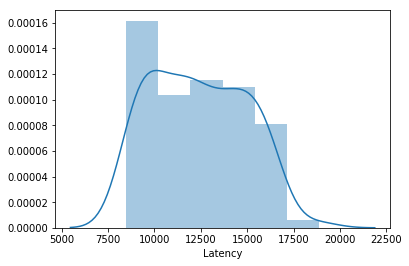

In [96]:
grp = df.groupby('Session')
dff = grp.get_group(20)
sns.distplot(dff.Latency)

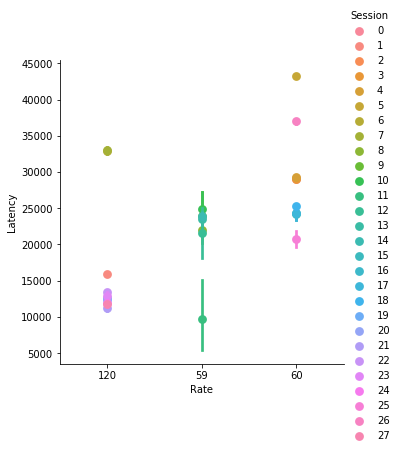

In [99]:
sns.catplot(x='Rate', y='Latency', hue='Session', kind="point", data=df)

## Same monitor, different parameters

In [176]:
df = df_params_latency.copy()

In [177]:
for ind, (name, dff) in enumerate(df.groupby('Monitors')):
    print(ind, name)

0 BNQ_BQ XL411_H6E00549SL0
1 SAM_SycMastr_H9XQB10798
2 SAM_SycMastr_H9XS904970
3 SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464
4 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009


In [195]:
grp = df.groupby('Monitors')
name = list(grp)[0][0]
df_mon = grp.get_group(name)
df_mon.head()

,Session,Trial,Latency,Experiment,Date,Time,Width,Height,Depth,Rate,Monitors,Trials,Filename
9440,17,2,25416.0,DisplayExperiment,30.08.2018,18:23:28,1920,1080,32,60,BNQ_BQ XL411_H6E00549SL0,100,display_20180830_182344
9441,17,3,21040.0,DisplayExperiment,30.08.2018,18:23:28,1920,1080,32,60,BNQ_BQ XL411_H6E00549SL0,100,display_20180830_182344
9442,17,4,17472.0,DisplayExperiment,30.08.2018,18:23:28,1920,1080,32,60,BNQ_BQ XL411_H6E00549SL0,100,display_20180830_182344
9443,17,5,22120.0,DisplayExperiment,30.08.2018,18:23:28,1920,1080,32,60,BNQ_BQ XL411_H6E00549SL0,100,display_20180830_182344
9444,17,6,16952.0,DisplayExperiment,30.08.2018,18:23:28,1920,1080,32,60,BNQ_BQ XL411_H6E00549SL0,100,display_20180830_182344


Monitor: BNQ_BQ XL411_H6E00549SL0


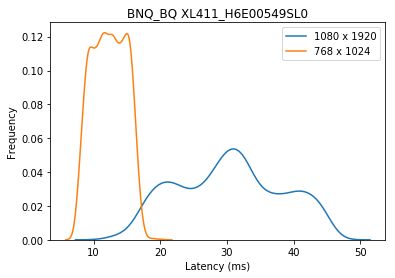

Monitor: SAM_SycMastr_H9XQB10798


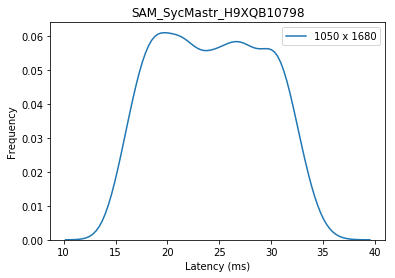

Monitor: SAM_SycMastr_H9XS904970
Monitor: SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464
Monitor: SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009


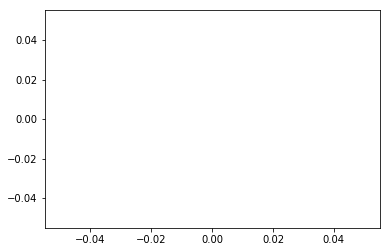

In [204]:
for name, df_mon in df.groupby('Monitors'):
    print('Monitor:', name)
    try:
        for (h, w), df_res in df_mon.groupby(['Height','Width']):
            sns.distplot(df_res.Latency / 1000, hist=False, label=h + ' x ' + w)
        
        plt.title(name)
        plt.xlabel('Latency (ms)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('C:/Users/Mohammad Bashiri/Desktop/single-mon' + name + '.png')
        plt.show()
    except ValueError:
        pass

Monitor: BNQ_BQ XL411_H6E00549SL0


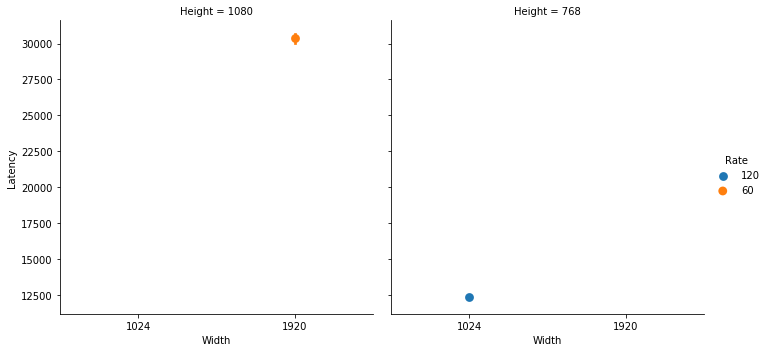

Monitor: SAM_SycMastr_H9XQB10798


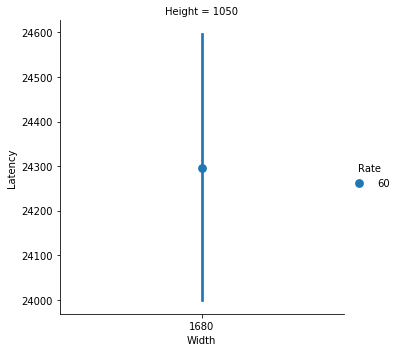

Monitor: SAM_SycMastr_H9XS904970


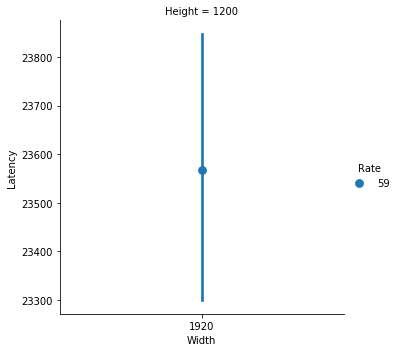

Monitor: SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464


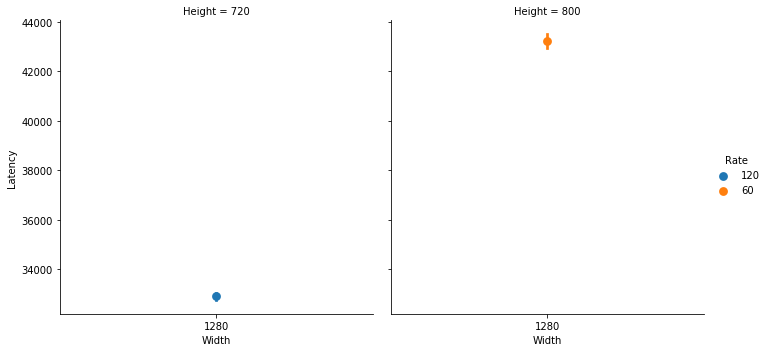

Monitor: SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009


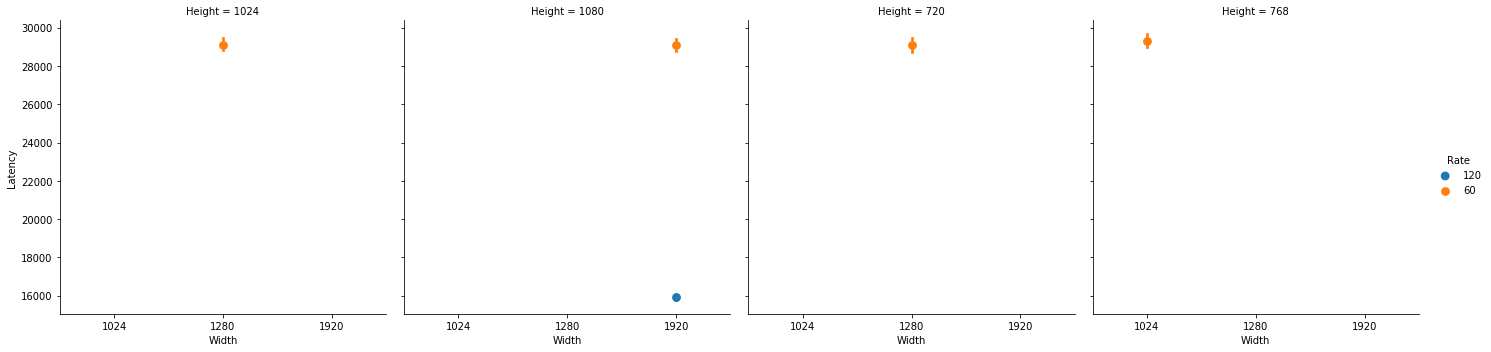

In [208]:
for name, df_mon in df.groupby('Monitors'):
    print('Monitor:', name)
    try:
        sns.catplot(x='Width', y='Latency', hue='Rate', col='Height', kind="point", data=df_mon)
        
#         plt.title(name)
#         plt.legend()
#         plt.savefig('C:/Users/Mohammad Bashiri/Desktop/single-mon' + name + '.png')
        plt.show()
    except ValueError:
        pass

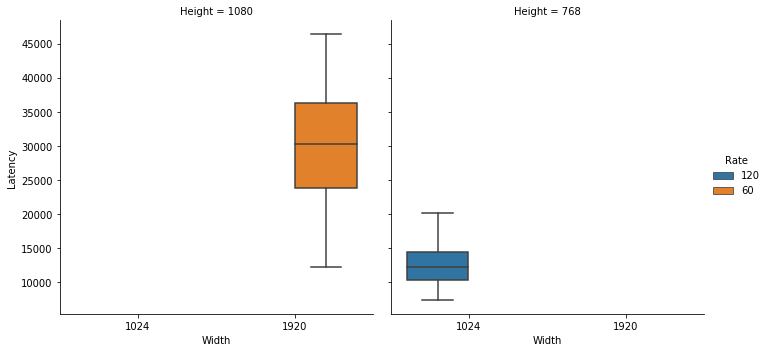

In [196]:
sns.catplot(x='Width', y='Latency', hue='Rate', col='Height', kind="box", data=df_mon)

## Same paramet different monitor

In [172]:
df = df_params_latency.copy()

In [173]:
grp = df.groupby(['Height', 'Width'])

('1024', '1280') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009']
('1050', '1680') ['SAM_SycMastr_H9XQB10798']
('1080', '1920') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009' 'BNQ_BQ XL411_H6E00549SL0']
('1200', '1920') ['SAM_SycMastr_H9XS904970']
('720', '1280') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009'
 'SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464']
('768', '1024') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009' 'BNQ_BQ XL411_H6E00549SL0']
('800', '1280') ['SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464']


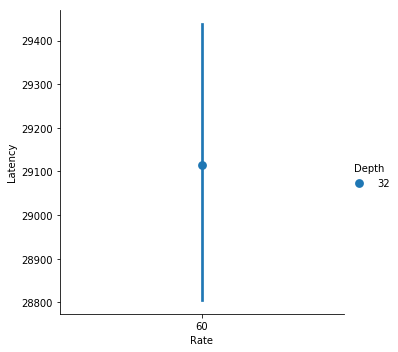

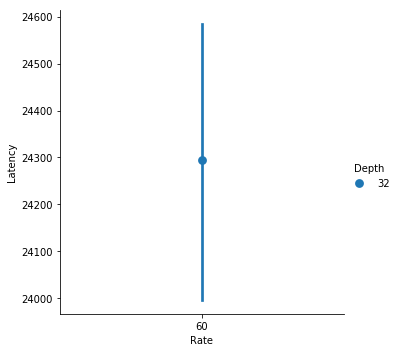

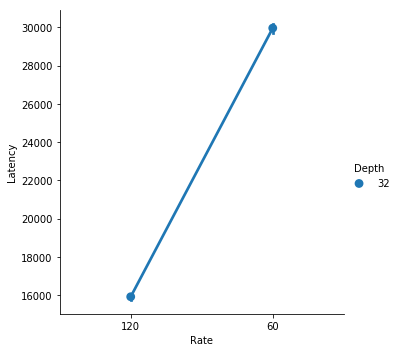

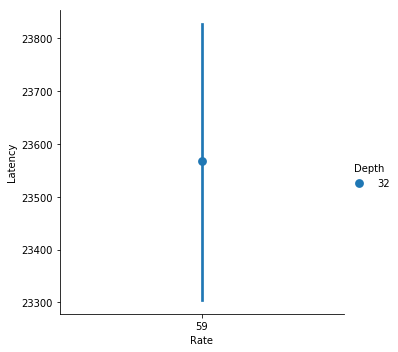

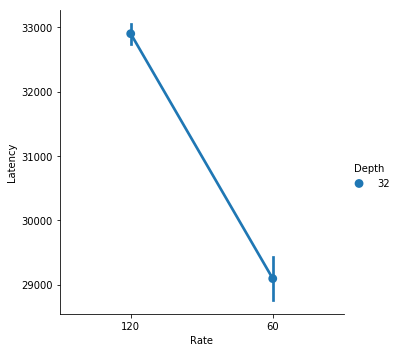

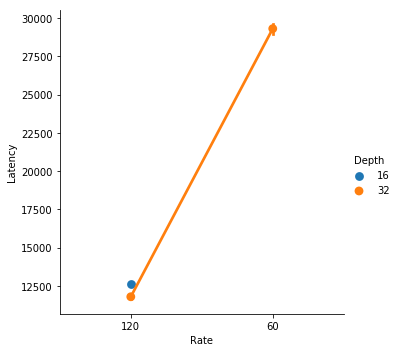

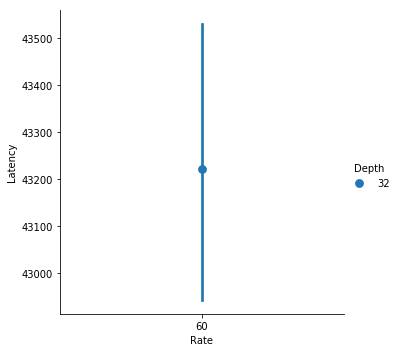

In [175]:
for name, dff in grp:
    print(name, dff.Monitors.unique())
    sns.catplot(x='Rate', y='Latency', hue='Depth', kind='point', data=dff)